In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2020 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
linreg :: Z -> R -> R -> P (RVec,R,R,R,RVec)
linreg n xMu xSigma = do
  x <- normals (vector [ xMu | i <- 1...n ]) (vector [ xSigma | i <- 1...n ])
  alpha <- normal 0 10
  beta <- normal 0 10
  sigma <- truncated 0 infinity (cauchy 0 5)
  y <- normals (cast alpha + (beta *> x)) (vector [ sigma | i <- 1...n ])
  return (x,alpha,beta,sigma,y)

In [3]:
linreg' :: P (Z,RVec,R,R,R,RVec)
linreg' = do
  n <- poisson 10
  (x,alpha,beta,sigma,y) <- linreg n 0 1
  guard $ sigma < 2
  return (n,x,alpha,beta,sigma,y)

In [4]:
(nData,xData,alphaTrue,betaTrue,sigmaTrue,yData) <- simulate linreg'
nData

8

In [5]:
:opt svg
import Language.Stochaskell.Plot

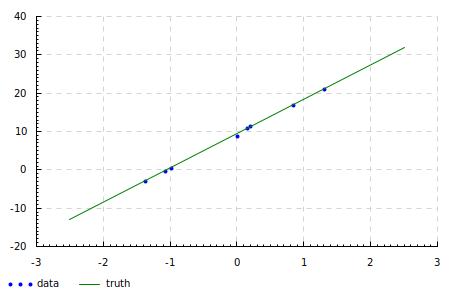

In [6]:
toRenderable $ do
  plot $ points "data" (list xData `zip` list yData)
  plot $ line "truth" [[(x, real alphaTrue + real betaTrue * x) | x <- [-2.5,2.5]]]

In [7]:
posterior = [ (alpha,beta,sigma) | (x,alpha,beta,sigma,y) <- linreg nData 0 1
                                 , x == xData, y == yData ]

In [8]:
samples <- hmcStan 1000 posterior

--- Generating Stan code ---
functions {
  // https://github.com/stan-dev/stan/issues/452
  real to_real(real x) { return x; }
}
data {
  vector[8] x_stan_0_0;
  
  
  
  vector[8] x_stan_0_4;
}
parameters {
  
  real x_stan_0_1;
  real x_stan_0_2;
  real<lower=0> x_stan_0_3;
  
}
model {
  
  
  
  vector[8] v_0_3;
  vector[8] v_0_4;
  
  vector[8] v_0_6;
  
  
  
  
  
  v_0_3 = x_stan_0_2 * x_stan_0_0;
  v_0_4 = x_stan_0_1 + v_0_3;
  
  for (i_1_1 in 1:8) {
  
    v_0_6[i_1_1] = x_stan_0_3;
  }
  
  

  
  x_stan_0_1 ~ normal(0, 10);
  x_stan_0_2 ~ normal(0, 10);
  x_stan_0_3 ~ cauchy(0, 5) T[0,];
  x_stan_0_4 ~ normal(v_0_4, v_0_6);
}

make -C /home/jovyan/stochaskell/cmdstan /home/jovyan/stochaskell/cache/stan/model_10a646b17ebb76a1b1f1fa35d92ec91da963e6ca
make[1]: Entering directory '/home/jovyan/stochaskell/cmdstan'

--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/stochaskell/cache/stan/model_10a646b17ebb76a1b1f1fa35d92ec91da963e6ca.hpp /home/jovyan/stocha

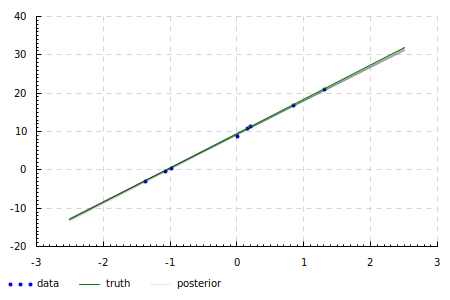

In [9]:
toRenderable $ do
  plot $ points "data" (list xData `zip` list yData)
  plot $ line "truth" [[(x, real alphaTrue + real betaTrue * x) | x <- [-2.5,2.5]]]
  setColors [black `withOpacity` 0.1]
  plot $ line "posterior" [[(x, real a + real b * x) | x <- [-2.5,2.5]] | (i,(a,b,s)) <- [0..] `zip` samples, i `mod` 100 == 0]

In [10]:
measurementError :: Z -> R -> P (R,R,RVec,RVec,R,R,R,RVec)
measurementError n tau = do
  xMu <- uniform (-10) 10
  xSigma <- uniform 0 10
  (x,alpha,beta,sigma,y) <- linreg n xMu xSigma
  xMeas <- normals x (vector [ tau | i <- 1...n ])
  return (xMu,xSigma,x,xMeas,alpha,beta,sigma,y)

In [11]:
(nTrue,xMu,xSigma,xTrue,xMeasData,alphaTrue,betaTrue,yData) <- simulate $ do
  n <- poisson 10
  (xMu,xSigma,x,xMeas,alpha,beta,sigma,y) <- measurementError n 1
  guard $ sigma < 2
  return (n,xMu,xSigma,x,xMeas,alpha,beta,y)

rejecting OOB sample -12.046149701419338
rejecting OOB sample -6.697030555008025

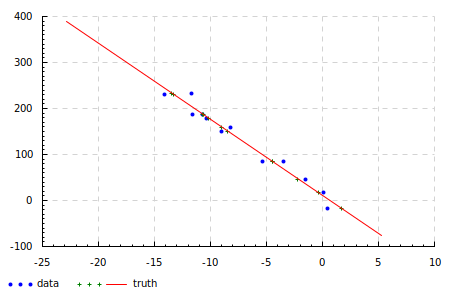

In [12]:
toRenderable $ do
  plot $ points "data" (list xMeasData `zip` list yData)
  plot $ points "truth" (list xTrue `zip` list yData)
  plot $ line "truth" [[(x, real alphaTrue + real betaTrue * x) | x <- [real xMu - 2.5 * real xSigma, real xMu + 2.5 * real xSigma]]]

In [13]:
samples <- hmcStanInit 1000 [ (xMu,xSigma,x,alpha,beta,sigma)
                            | (xMu,xSigma,x,xMeas,alpha,beta,sigma,y) <- measurementError nTrue 1
                            , xMeas == xMeasData, y == yData ]
                       (0,1,xMeasData,0,0,1)

--- Generating Stan code ---
functions {
  // https://github.com/stan-dev/stan/issues/452
  real to_real(real x) { return x; }
}
data {
  
  
  
  
  
  
  vector[12] x_stan_0_6;
  vector[12] x_stan_0_7;
}
parameters {
  real x_stan_0_0;
  real x_stan_0_1;
  vector[12] x_stan_0_2;
  real x_stan_0_3;
  real x_stan_0_4;
  real<lower=0> x_stan_0_5;
  
  
}
model {
  
  vector[12] v_0_1;
  
  
  vector[12] v_0_4;
  vector[12] v_0_5;
  
  vector[12] v_0_7;
  
  vector[12] v_0_9;
  
  vector[12] v_0_11;
  
  for (i_1_1 in 1:12) {
  
    v_0_1[i_1_1] = 1;
  }
  
  
  v_0_4 = x_stan_0_4 * x_stan_0_2;
  v_0_5 = x_stan_0_3 + v_0_4;
  
  for (i_1_1 in 1:12) {
  
    v_0_7[i_1_1] = x_stan_0_5;
  }
  
  for (i_1_1 in 1:12) {
  
    v_0_9[i_1_1] = x_stan_0_0;
  }
  
  for (i_1_1 in 1:12) {
  
    v_0_11[i_1_1] = x_stan_0_1;
  }

  x_stan_0_0 ~ uniform(-10, 10);
  x_stan_0_1 ~ uniform(0, 10);
  x_stan_0_2 ~ normal(v_0_9, v_0_11);
  x_stan_0_3 ~ normal(0, 10);
  x_stan_0_4 ~ normal(0, 10);
  x_stan_0_

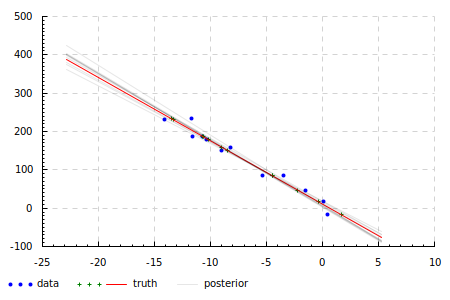

In [14]:
let endpoints = [real xMu - 2.5 * real xSigma, real xMu + 2.5 * real xSigma]
toRenderable $ do
  plot $ points "data" (list xMeasData `zip` list yData)
  plot $ points "truth" (list xTrue `zip` list yData)
  plot $ line "truth" [[(x, real alphaTrue + real betaTrue * x) | x <- endpoints]]
  setColors [black `withOpacity` 0.1]
  plot $ line "posterior" [[(x, real a + real b * x) | x <- endpoints] | (i,(_,_,_,a,b,_)) <- [0..] `zip` samples, i `mod` 100 == 0]